In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.colors as mplcolors
import matplotlib.ticker as ptick
import matplotlib.colorbar as mplcolorbar
import matplotlib.cm as mplcm
from matplotlib.ticker import AutoMinorLocator
import math
import Leadangle_wave as Wave
from Leadangle_fit_JunoUVS import eqwlong_err
from Leadangle_fit_JunoUVS import TEB_transit
from Leadangle_fit_JunoUVS import create_argmesh
from column_mass import calc as column_calc
from UniversalColor import UniversalColor
from SharedX import ShareXaxis
from legend_shadow import legend_shadow

UC = UniversalColor()
UC.set_palette()

F = ShareXaxis()
F.fontsize = 20
F.fontname = 'Liberation Sans Narrow'
F.set_default()

# F.set_figparams()
# F.initialize()

Importing Library
done


In [2]:
exname = '003/20250516_068'
TARGET_MOON = 'Io'
target_fp = ['MAW', 'TEB']
PJ_num = ['19']
Ai_num = 3
ni_num = 50
Ti_num = 60
Zi = 1.4
Te = 20.0  # [eV]


chi2_1d = np.loadtxt('results/fit/'+exname+'/params_chi2.txt')
Ai_1d = np.loadtxt('results/fit/'+exname+'/params_Ai.txt')
ni_1d = np.loadtxt('results/fit/'+exname+'/params_ni.txt')
Ti_1d = np.loadtxt('results/fit/'+exname+'/params_Ti.txt')
H_1d = np.loadtxt('results/fit/'+exname+'/params_H.txt')
eqlead_est = np.loadtxt('results/fit/'+exname+'/eqlead_est.txt')
eqlead_obs = np.loadtxt('results/fit/'+exname+'/eqlead_obs.txt')
sigma_total = np.loadtxt('results/fit/'+exname+'/sigma_y.txt')
hem_obs = np.loadtxt('results/fit/'+exname+'/hems_obs.txt')
moon_S3wlon_obs = np.loadtxt('results/fit/'+exname+'/moon_S3wlon_obs.txt')
print(chi2_1d.shape)
print(eqlead_est.shape)

chi2_3d = chi2_1d.reshape(ni_num, Ai_num, Ti_num)
H_3d = H_1d.reshape(ni_num, Ai_num, Ti_num)
Ai_3d = Ai_1d.reshape(ni_num, Ai_num, Ti_num)
ni_3d = ni_1d.reshape(ni_num, Ai_num, Ti_num)
Ti_3d = Ti_1d.reshape(ni_num, Ai_num, Ti_num)
eqlead_est_3d = eqlead_est[1].reshape(ni_num, Ai_num, Ti_num)

# 保存されているカイ2乗値は自由度で割ってしまっているので
# ここで元に戻す
chi2_3d = chi2_3d*(eqlead_est.shape[0]-3)

sigma_obs = sigma_total

print('Parameter ranges:')
print('Ai:', np.min(Ai_3d), np.max(Ai_3d))
print('ni:', np.min(ni_3d), np.max(ni_3d))
print('Ti:', np.min(Ti_3d), np.max(Ti_3d))
print('Hi:', np.min(H_3d)/71492E+3, np.max(H_3d)/71492E+3)
print('Degree of freedom:', (eqlead_est.shape[0]-3))

(9000,)
(21, 9000)
Parameter ranges:
Ai: 20.0 24.0
ni: 499.9999999999999 4999.9999999999945
Ti: 9.999999999999998 999.9999999999999
Hi: 0.5511684557979226 4.543098502123853
Degree of freedom: 18


In [3]:
column_mass_1dN = np.loadtxt(
    'results/column_mass/002/20250427_'+TARGET_MOON+'/col_massdens_1dN.txt')
column_mass_1dS = np.loadtxt(
    'results/column_mass/002/20250427_'+TARGET_MOON+'/col_massdens_1dS.txt')
column_mass_3dN = column_mass_1dN.reshape(ni_num, Ai_num, Ti_num)
column_mass_3dS = column_mass_1dS.reshape(ni_num, Ai_num, Ti_num)
column_mass_3d = column_mass_3dN+column_mass_3dS

In [4]:
# %% Constants
dchi_1s = 2.30     # デルタchi2の1シグマ区間
dchi_2s = 6.17     # デルタchi2の2シグマ区間
dchi_3s = 11.8     # デルタchi2の3シグマ区間

MU0 = 1.26E-6            # 真空中の透磁率
AMU2KG = 1.66E-27        # 原子質量をkgに変換するファクタ [kg]
RJ = 71492E+3            # JUPITER RADIUS [m]
MJ = 1.90E+27            # JUPITER MASS [kg]
C = 2.99792E+8           # LIGHT SPEED [m/s]
G = 6.67E-11             # 万有引力定数  [m^3 kg^-1 s^-2]

Psyn_io = (12.89)*3600      # Moon's synodic period [sec]
Psyn_eu = (11.22)*3600      # Moon's synodic period [sec]
Psyn_ga = (10.53)*3600      # Moon's synodic period [sec]

if TARGET_MOON == 'Io':
    Psyn = Psyn_io
    r_moon = 5.9*RJ
    xticks = np.array([1, 10, 100, 500, 1000, 5000])
elif TARGET_MOON == 'Europa':
    Psyn = Psyn_eu
    r_moon = 9.4*RJ
    xticks = np.array([1, 10, 100, 500, 1000, 5000])
elif TARGET_MOON == 'Ganymede':
    Psyn = Psyn_ga
    r_moon = 15.0*RJ
    xticks = np.array([1, 10, 100, 1000])

sigma_x = eqwlong_err(Psyn, dt=22.5)*np.ones(sigma_obs.shape)
print('sigma_x [deg]:', sigma_x)

sigma_x [deg]: [0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392 0.17455392
 0.17455392 0.17455392 0.17455392]


In [5]:
print(sigma_obs)

[0.42455392 0.42455392 0.42455392 0.42455392 0.57455354 0.62455468
 0.5245543  0.5245543  0.5245543  0.57455354 0.57455354 0.57455354
 0.57455544 0.57455544 0.57455544 0.57455544 0.57455544 0.62455087
 0.62455087 0.57455544 0.42455392]


In [6]:
min_idx = np.where(chi2_3d == np.min(chi2_3d))
print('Min chi2:', np.min(chi2_3d), 'at', min_idx)

print('Scale height [RJ]:', H_3d[min_idx][0]/(71492*1E+3))
print('Estimated eqlead [deg]:', eqlead_est_3d[min_idx][0])
print('Observed eqlead [deg]:', eqlead_obs[1])

Min chi2: 4.192669322023334 at (array([35]), array([1]), array([23]))
Scale height [RJ]: 1.1252568160344711
Estimated eqlead [deg]: 5.356422730964649
Observed eqlead [deg]: 5.335689848280197


In [7]:
print(min_idx[0][0])

35


(60, 50)
Best fit for A_i = 20.0 amu
             n_i = 2714.337719661928 cm-3
             T_i = 55.688139909452694 eV
(60, 50)
Best fit for A_i = 22.0 amu
             n_i = 2589.7373396156036 cm-3
             T_i = 60.2089449333613 eV
(60, 50)
Best fit for A_i = 24.0 amu
             n_i = 2249.21633448472 cm-3
             T_i = 70.38135554931559 eV


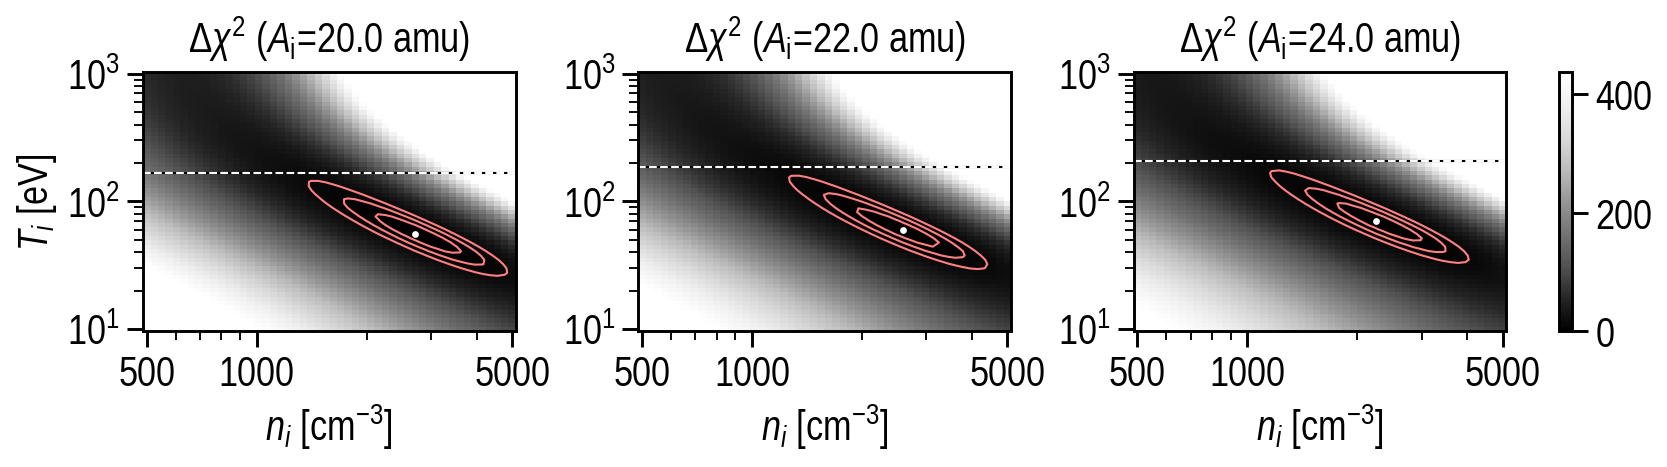

In [8]:
# 横軸 ni
fig, ax = plt.subplots(1, 3, figsize=(11, 3), dpi=150, layout='constrained')
for i in range(3):
    z_value = chi2_3d[:, i, :].T-np.min(chi2_3d[:, i, :])
    print(z_value.shape)

    x_value = ni_3d[:, i, :].T
    y_value = Ti_3d[:, i, :].T

    # Scale height (2.0 RJ) -> Ti
    Ti_thres = ((2.0*RJ)**2)*Ai_3d[0, i, 0]/((0.64*RJ)**2) - Zi*Te

    ax[i].set_title(
        r'$\Delta \chi^2$ ($A_{\rm i}$='+str(Ai_3d[0, i, 0])+' amu)')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticks)
    cn = ax[i].contour(x_value, y_value, z_value,
                       levels=[2.30, 6.17, 11.8],
                       # levels=[21.36, 30.48, 40.29],
                       colors=UC.pink,
                       linewidths=1.0,
                       zorder=2)
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         cmap='Greys_r',
                         vmin=0, vmax=np.std(z_value), zorder=0.5)

    # Location of the chi2 minimum
    x_best = x_value[np.where(z_value == np.min(z_value))]
    y_best = y_value[np.where(z_value == np.min(z_value))]
    ax[i].scatter(x_best, y_best,
                  s=5, color='w', zorder=2.5)

    # Threshold temperature
    ax[i].axhline(y=Ti_thres, linewidth=1.0, color='k')
    ax[i].axhline(y=Ti_thres, linewidth=1.0, linestyle='--', color='w')

    if TARGET_MOON == 'Europa':
        ax[i].scatter(1207/18, 87,
                      s=7, color=UC.lightblue,
                      marker='*', zorder=2.5)
        ax[i].scatter(1708/18, 195,
                      s=7, color=UC.lightblue,
                      marker='+', zorder=2.5)

    # Best fit parameter
    print('Best fit for A_i = '+str(Ai_3d[0, i, 0])+' amu')
    print('             n_i = '+str(x_best[0])+' cm-3')
    print('             T_i = '+str(y_best[0])+' eV')

fig.colorbar(p)
plt.show()

(60, 50)
(60, 50)
(60, 50)


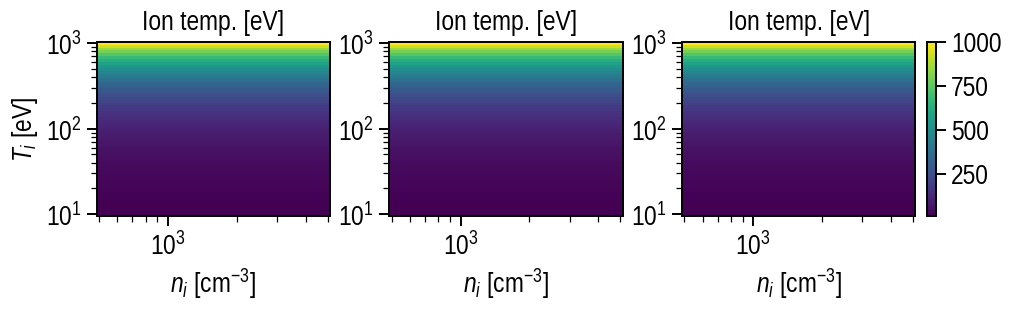

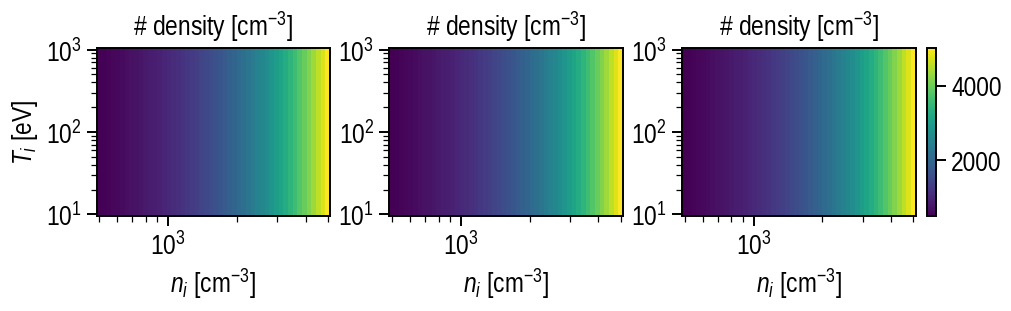

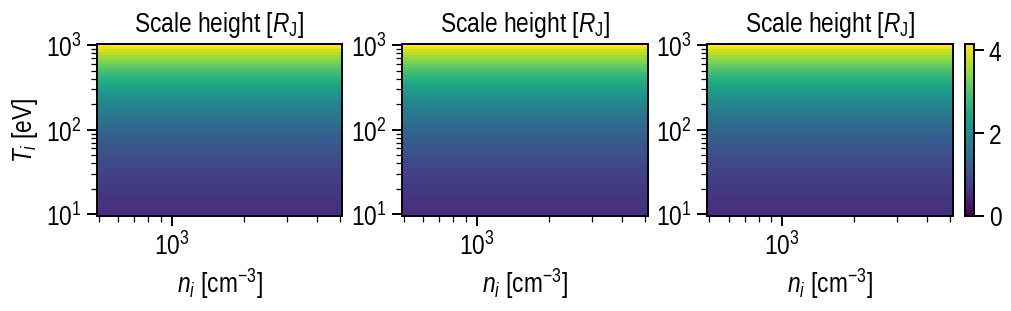

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
for i in range(3):
    z_value = Ti_3d[::, i, ::].T
    print(z_value.shape)

    x_value = ni_3d[::, i, ::].T
    x_value = x_value[0, :]
    y_value = Ti_3d[::, i, ::].T
    y_value = y_value[:, 0]

    ax[i].set_title(r'Ion temp. [eV]')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         vmin=np.min(z_value), vmax=np.max(z_value))

fig.colorbar(p)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
for i in range(3):
    z_value = ni_3d[::, i, ::].T
    # print(z_value.shape)

    x_value = ni_3d[::, i, ::].T
    x_value = x_value[0, :]
    y_value = Ti_3d[::, i, ::].T
    y_value = y_value[:, 0]

    ax[i].set_title(r'# density [cm$^{-3}$]')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         vmin=np.min(z_value), vmax=np.max(z_value))

fig.colorbar(p)
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
for i in range(3):
    z_value = (H_3d[::, i, ::].T)/RJ
    # print(z_value.shape)

    x_value = ni_3d[::, i, ::].T
    x_value = x_value[0, :]
    y_value = Ti_3d[::, i, ::].T
    y_value = y_value[:, 0]

    ax[i].set_title(r'Scale height [$R_{\rm J}$]')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         vmin=0, vmax=np.max(z_value))

fig.colorbar(p)
plt.show()

(60, 50)
Best fit for A_i = 20.0 amu
             n_i = 2714.337719661928 cm-3
             T_i = 55.688139909452694 eV
             (1) Highest n_i = 4770.477381749965 cm-3
             (1) Lowest T_i = 27.58531617629183 eV
             (2) Lowest n_i = 1405.8843489871147 cm-3
             (2) Hightest T_i = 142.0830832533923 eV
(60, 50)
Best fit for A_i = 22.0 amu
             n_i = 2589.7373396156036 cm-3
             T_i = 60.2089449333613 eV
             (1) Highest n_i = 4342.556868756759 cm-3
             (1) Lowest T_i = 29.824712862168912 eV
             (2) Lowest n_i = 1279.7739613497674 cm-3
             (2) Hightest T_i = 153.6174946671829 eV
(60, 50)
Best fit for A_i = 24.0 amu
             n_i = 2249.21633448472 cm-3
             T_i = 70.38135554931559 eV
             (1) Highest n_i = 3953.0216054538478 cm-3
             (1) Lowest T_i = 34.86365227678084 eV
             (2) Lowest n_i = 1164.9759052576849 cm-3
             (2) Hightest T_i = 166.08827826277152 eV


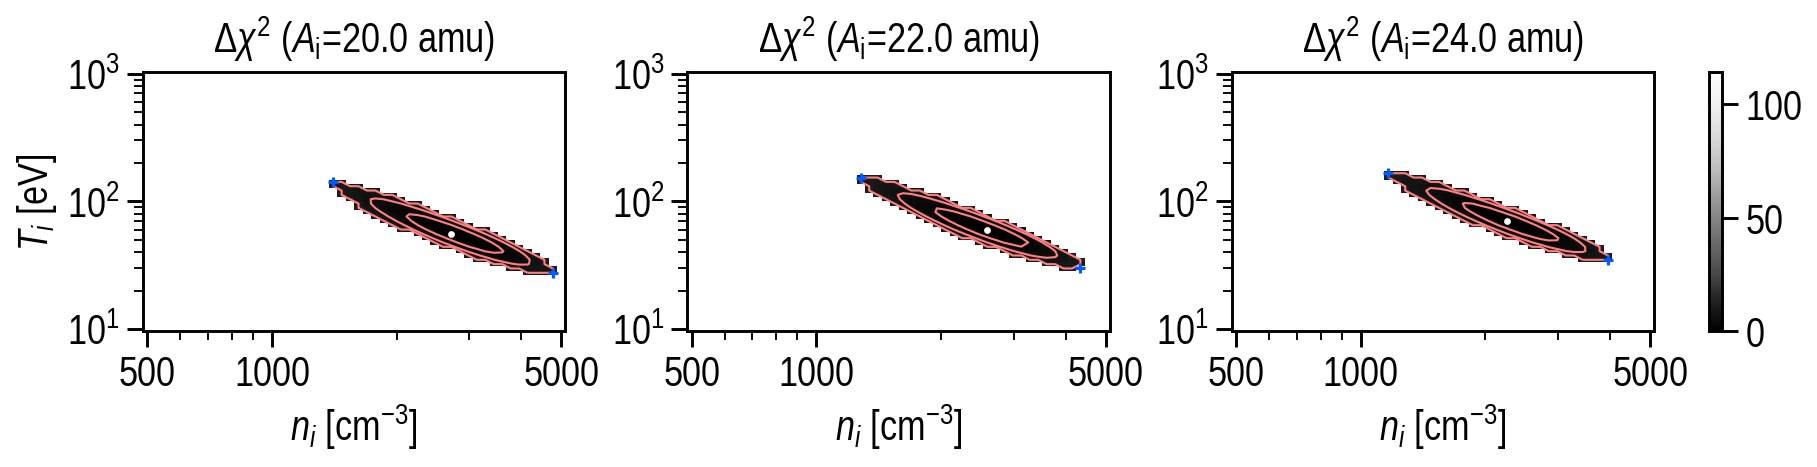

In [10]:
# 横軸 ni
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=150, layout='constrained')
for i in range(3):
    z_value = chi2_3d[:, i, :].T-np.min(chi2_3d[:, i, :])
    print(z_value.shape)

    x_value = ni_3d[:, i, :].T
    y_value = Ti_3d[:, i, :].T

    z_value = np.where(z_value < 11.8, z_value, 500)

    ax[i].set_title(
        r'$\Delta \chi^2$ ($A_{\rm i}$='+str(Ai_3d[0, i, 0])+' amu)')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticks)
    cn = ax[i].contour(x_value, y_value, z_value,
                       levels=[2.30, 6.17, 11.8],
                       # levels=[21.36, 30.48, 40.29],
                       colors=UC.pink,
                       linewidths=1.0,
                       zorder=2)
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         cmap='Greys_r',
                         vmin=0, vmax=np.std(z_value), zorder=0.5)

    # Location of the chi2 minimum
    x_best = x_value[np.where(z_value == np.min(z_value))]
    y_best = y_value[np.where(z_value == np.min(z_value))]
    ax[i].scatter(x_best, y_best,
                  s=5, color='w', zorder=2.5)

    if TARGET_MOON == 'Europa':
        ax[i].scatter(1207/18, 87,
                      s=7, color=UC.lightblue,
                      marker='*', zorder=2.5)
        ax[i].scatter(1708/18, 195,
                      s=7, color=UC.lightblue,
                      marker='+', zorder=2.5)

    # Best fit parameter
    print('Best fit for A_i = '+str(Ai_3d[0, i, 0])+' amu')
    print('             n_i = '+str(x_best[0])+' cm-3')
    print('             T_i = '+str(y_best[0])+' eV')

    # Lowest temperature
    x_value_mask = x_value[np.where(z_value < 11.8)]
    y_value_mask = y_value[np.where(z_value < 11.8)]
    print('             (1) Highest n_i = '+str(x_value_mask.max())+' cm-3')
    print('             (1) Lowest T_i = '+str(y_value_mask.min())+' eV')
    ax[i].scatter(x_value_mask.max(),
                  y_value_mask.min(),
                  marker='+',
                  s=20, color=UC.blue, zorder=2.5)

    # Lowest temperature
    print('             (2) Lowest n_i = '+str(x_value_mask.min())+' cm-3')
    print('             (2) Hightest T_i = '+str(y_value_mask.max())+' eV')
    ax[i].scatter(x_value_mask.min(),
                  y_value_mask.max(),
                  marker='+',
                  s=20, color=UC.blue, zorder=2.5)

fig.colorbar(p)
plt.show()

(60, 50)
Best fit for A_i = 20.0 amu
             n_i = 2249.21633448472 cm-3
             T_i = 70.38135554931559 eV
(60, 50)
Best fit for A_i = 22.0 amu
             n_i = 2249.21633448472 cm-3
             T_i = 70.38135554931559 eV
(60, 50)
Best fit for A_i = 24.0 amu
             n_i = 2249.21633448472 cm-3
             T_i = 70.38135554931559 eV


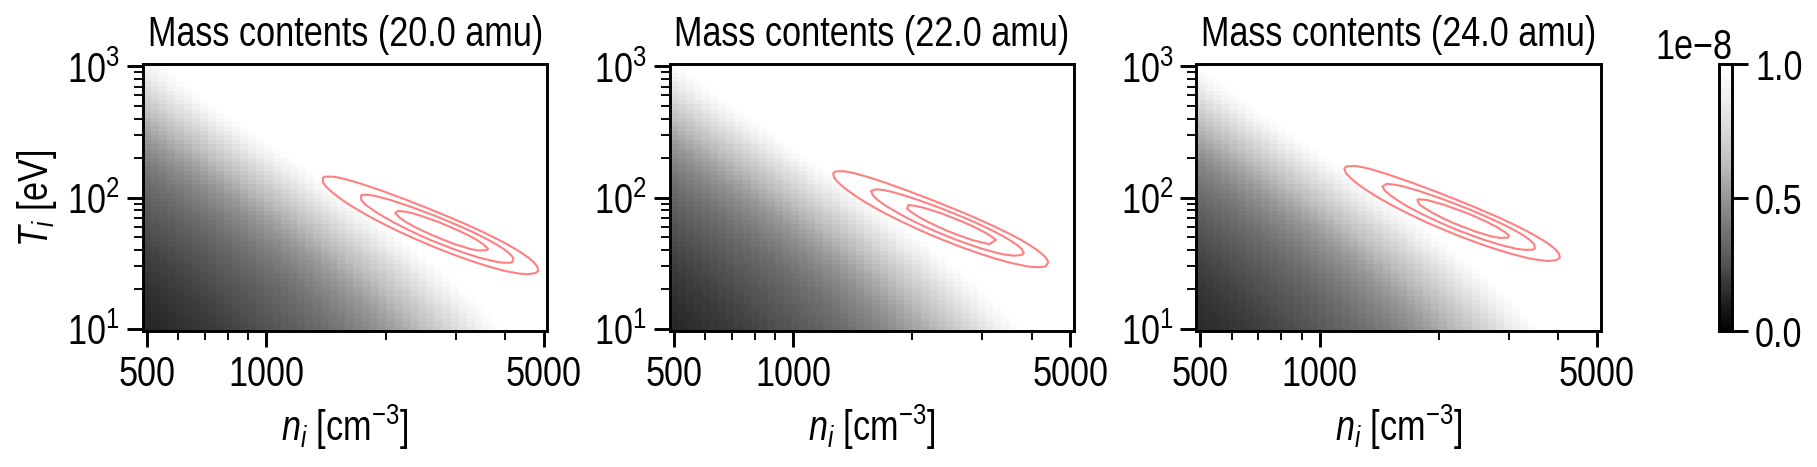

In [11]:
# 横軸 ni
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=150, layout='constrained')
for i in range(3):
    z_value = chi2_3d[:, i, :].T-np.min(chi2_3d[:, i, :])
    print(z_value.shape)

    x_value = ni_3d[:, i, :].T
    y_value = Ti_3d[:, i, :].T

    ax[i].set_title(
        r'Mass contents ('+str(Ai_3d[0, i, 0])+' amu)')
    ax[i].set_xlabel(r'$n_i$ [cm$^{-3}$]')
    ax[0].set_ylabel(r'$T_i$ [eV]')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticks)
    cn = ax[i].contour(x_value, y_value, z_value,
                       levels=[2.30, 6.17, 11.8],
                       # levels=[21.36, 30.48, 40.29],
                       colors=UC.pink,
                       linewidths=1.0,
                       zorder=2)

    z_value = column_mass_3d[:, i, :].T
    p = ax[i].pcolormesh(x_value,
                         y_value,
                         z_value,
                         cmap='Greys_r',
                         vmin=0, vmax=1E-8, zorder=0.5)

    if TARGET_MOON == 'Europa':
        ax[i].scatter(1207/18, 87,
                      s=7, color=UC.lightblue,
                      marker='*', zorder=2.5)
        ax[i].scatter(1708/18, 195,
                      s=7, color=UC.lightblue,
                      marker='+', zorder=2.5)

    # Best fit parameter
    print('Best fit for A_i = '+str(Ai_3d[0, i, 0])+' amu')
    print('             n_i = '+str(x_best[0])+' cm-3')
    print('             T_i = '+str(y_best[0])+' eV')

fig.colorbar(p)
plt.show()

In [12]:
Ai_2d = Ai_3d[:, 0, :]
ni_2d = ni_3d[:, 0, :]
H_2d = H_3d[:, 0, :]
Ti_2d = Ti_3d[:, 0, :]
chi2_2d = chi2_3d[:, 0, :]-np.min(chi2_3d[:, 0, :])
column_mass_2d = column_mass_3d[:, 0, :]

Ai_2d = Ai_2d[np.where(chi2_2d < dchi_3s)]
ni_2d = ni_2d[np.where(chi2_2d < dchi_3s)]
H_2d = H_2d[np.where(chi2_2d < dchi_3s)]
Ti_2d = Ti_2d[np.where(chi2_2d < dchi_3s)]
column_mass_2d = column_mass_2d[np.where(chi2_2d < dchi_3s)]
chi2_2d = chi2_2d[np.where(chi2_2d < dchi_3s)]   # 一番最後に

print(chi2_2d.shape)

"""H_thres = 2.0*RJ
Ai_2d = Ai_2d[np.where(H_2d < H_thres)]
ni_2d = ni_2d[np.where(H_2d < H_thres)]
Ti_2d = Ti_2d[np.where(H_2d < H_thres)]
column_mass_2d = column_mass_2d[np.where(H_2d < H_thres)]
chi2_2d = chi2_2d[np.where(H_2d < H_thres)]
H_2d = H_2d[np.where(H_2d < H_thres)]  # 一番最後に"""

print(chi2_2d.shape)

(176,)
(176,)


(array([20., 26., 28., 24., 24., 18., 15., 13.,  8.]),
 array([9.59084543e-09, 1.05155253e-08, 1.14402052e-08, 1.23648851e-08,
        1.32895649e-08, 1.42142448e-08, 1.51389247e-08, 1.60636046e-08,
        1.69882844e-08, 1.79129643e-08]),
 <BarContainer object of 9 artists>)

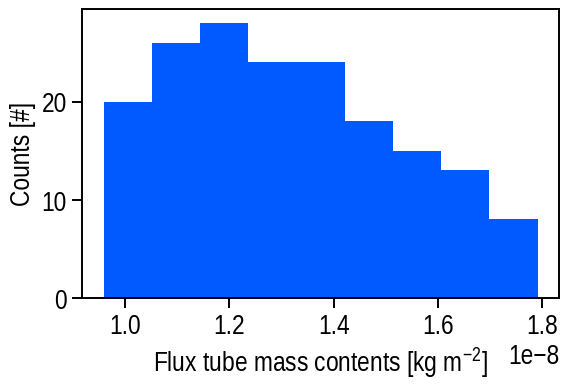

In [13]:
F = ShareXaxis()
F.fontsize = 20
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(6, 4), dpi='S')
F.initialize()

F.ax.set_xlabel(r'Flux tube mass contents [kg m$^{-2}$]')
F.ax.set_ylabel(r'Counts [#]')
F.ax.hist(column_mass_2d, color=UC.blue, bins='auto')

1.2896248958559507e-08


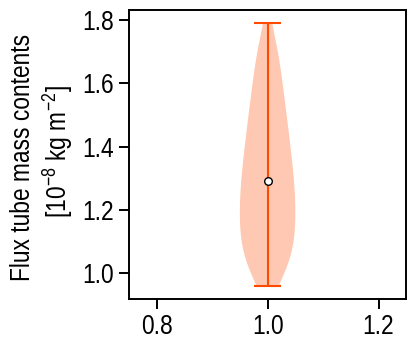

In [14]:
F = ShareXaxis()
F.fontsize = 20
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(4, 4), dpi='S')
F.initialize()
F.ax.set_xlim(0.75, 1.25)
F.ax.set_ylabel('Flux tube mass contents \n [10$^{-8}$ kg m$^{-2}$]')
quartile1, medians, quartile3 = np.percentile(
    column_mass_2d, [25, 50, 75], axis=0)
parts = F.ax.violinplot(column_mass_2d*1E+8,
                        widths=0.1)
F.ax.scatter(1.0, medians*1E+8, s=30, marker='o',
             edgecolor='k', facecolor='w',
             zorder=2.0)

print(medians)

In [15]:
# Moon position when the Alfven waves launched (Time: t0-tau_A)
r_A0_arr = r_moon*np.ones(56)
S3wlon_A0_arr = np.linspace(-50, 370, r_A0_arr.size)
Ai_best = Ai_3d[min_idx][0]
ni_best = ni_3d[min_idx][0]
Hp_best = H_3d[min_idx][0]

eqlead_best_MAW_N = np.zeros(r_A0_arr.size)
eqlead_best_MAW_S = np.zeros(r_A0_arr.size)
eqlead_best_TEB_N = np.zeros(r_A0_arr.size)
eqlead_best_TEB_S = np.zeros(r_A0_arr.size)
TEB_dt_arr = np.zeros(r_A0_arr.size)
for i in range(r_A0_arr.size):
    r_A0 = r_A0_arr[i]
    S3wlon_A0 = S3wlon_A0_arr[i]
    S_A0 = Wave.Awave().tracefield(r_A0,
                                   np.radians(S3wlon_A0),
                                   1
                                   )
    tau, _, _, _ = Wave.Awave().trace3(r_A0,
                                       np.radians(S3wlon_A0),
                                       0,
                                       S_A0,
                                       Ai_best,
                                       ni_best,
                                       Hp_best,
                                       -1
                                       )

    eqlead_best_MAW_N[i] = tau*360/Psyn     # [deg]
    TEB_dt_arr[i] = TEB_transit(r_A0, S3wlon_A0, TARGET_MOON)
    eqlead_best_TEB_S[i] = (tau+TEB_dt_arr[i])*360/Psyn     # [deg]

    tau, _, _, _ = Wave.Awave().trace3(r_A0,
                                       np.radians(S3wlon_A0),
                                       0,
                                       S_A0,
                                       Ai_best,
                                       ni_best,
                                       Hp_best,
                                       1
                                       )

    eqlead_best_MAW_S[i] = tau*360/Psyn     # [deg]
    eqlead_best_TEB_N[i] = (tau+TEB_dt_arr[i])*360/Psyn     # [deg]

Tracing field line 1 of 1 (100.00)%


Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (100.00)%
Tracing field line 1 of 1 (

In [16]:
print(TEB_dt_arr)
print(np.average(TEB_dt_arr))

[3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922 3.52552922
 3.52552922 3.52552922]
3.5255292200522037


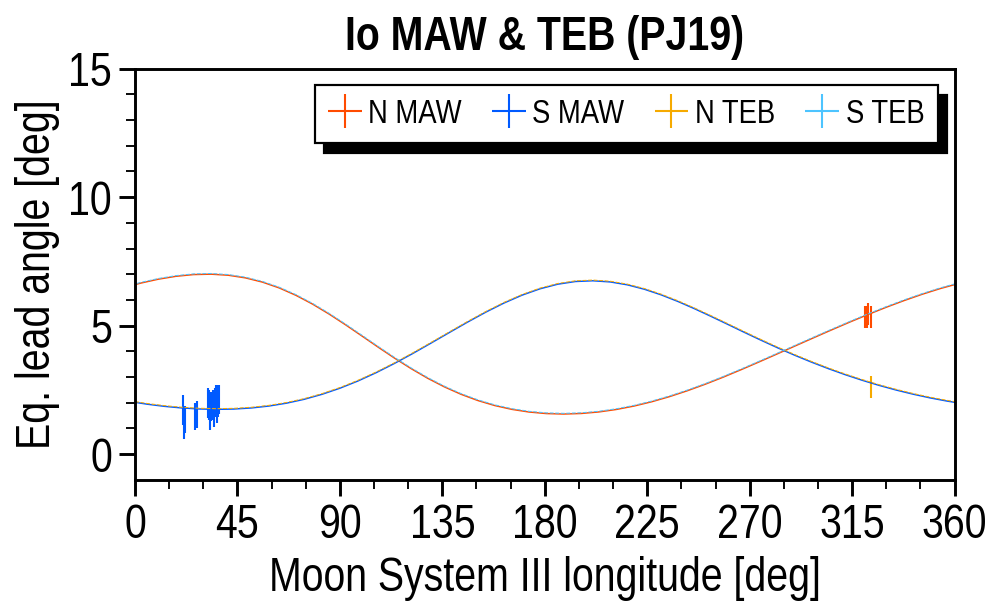

In [17]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'

F.set_figparams(nrows=1, figsize=(7, 4), dpi='M')
F.initialize()

ymax = 1
if TARGET_MOON == 'Io':
    ymax = 15
elif TARGET_MOON == 'Europa':
    ymax = 15
elif TARGET_MOON == 'Ganymede':
    ymax = 40

F.set_xaxis(label='Moon System III longitude [deg]',
            min=0, max=360,
            ticks=np.arange(0, 360+1, 45),
            ticklabels=np.arange(0, 360+1, 45),
            minor_num=3)
F.set_yaxis(ax_idx=0, label='Eq. lead angle [deg]',
            min=-1, max=ymax,
            ticks=np.arange(0, ymax+1, 5),
            ticklabels=np.arange(0, ymax+1, 5),
            minor_num=5)

north = np.where((hem_obs == -1))
F.ax.errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
              xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
              yerr=np.array([np.abs(sigma_obs[north]),
                             np.abs(sigma_obs[north])]),
              linewidth=0., markersize=2,
              elinewidth=1.0, color=UC.red,
              label='N MAW',
              zorder=0.7)

south = np.where((hem_obs == 1))
F.ax.errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
              xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
              yerr=np.array([np.abs(sigma_obs[south]),
                             np.abs(sigma_obs[south])]),
              linewidth=0., markersize=2,
              elinewidth=1.0, color=UC.blue,
              label='S MAW',
              zorder=0.7)

if len(target_fp) == 2:
    north = np.where((hem_obs == -101))
    F.ax.errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
                  xerr=np.array([np.abs(sigma_x[north]),
                                 np.abs(sigma_x[north])]),
                  yerr=np.array([np.abs(sigma_obs[north]),
                                 np.abs(sigma_obs[north])]),
                  linewidth=0., markersize=2,
                  elinewidth=1.0, color=UC.orange,
                  label='N TEB',
                  zorder=0.7)
    south = np.where((hem_obs == 101))
    F.ax.errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
                  xerr=np.array([np.abs(sigma_x[south]),
                                 np.abs(sigma_x[south])]),
                  yerr=np.array([np.abs(sigma_obs[south]),
                                 np.abs(sigma_obs[south])]),
                  linewidth=0., markersize=2,
                  elinewidth=1.0, color=UC.lightblue,
                  label='S TEB',
                  zorder=0.7)

F.ax.plot(S3wlon_A0_arr+eqlead_best_MAW_N,
          eqlead_best_MAW_N, color=UC.red, linewidth=0.7)
F.ax.plot(S3wlon_A0_arr+eqlead_best_MAW_S,
          eqlead_best_MAW_S, color=UC.blue, linewidth=0.7)

if len(target_fp) == 2:
    F.ax.plot(S3wlon_A0_arr+eqlead_best_TEB_N,
              eqlead_best_TEB_N, color=UC.orange,
              linestyle='--', linewidth=0.5)
    F.ax.plot(S3wlon_A0_arr+eqlead_best_TEB_S,
              eqlead_best_TEB_S, color=UC.lightblue,
              linestyle='--', linewidth=0.5)

fig_title = TARGET_MOON
for i in range(len(target_fp)):
    if i == 0:
        fig_title += ' '+target_fp[i]
    elif i > 0:
        fig_title += ' & '+target_fp[i]
fig_title += ' (PJ'
for i in range(len(PJ_num)):
    if i == 0:
        fig_title += PJ_num[i]
    elif i > 0:
        fig_title += ' & '+PJ_num[i]
fig_title += ')'
F.ax.set_title(fig_title, fontsize=F.fontsize, weight='bold')

legend = F.legend(ax_idx=0, loc='upper right', ncol=4, markerscale=4,
                  fontsize_scale=0.7, textcolor=False, handletextpad=0.2)
legend_shadow(fig=F.fig, ax=F.ax, legend=legend)

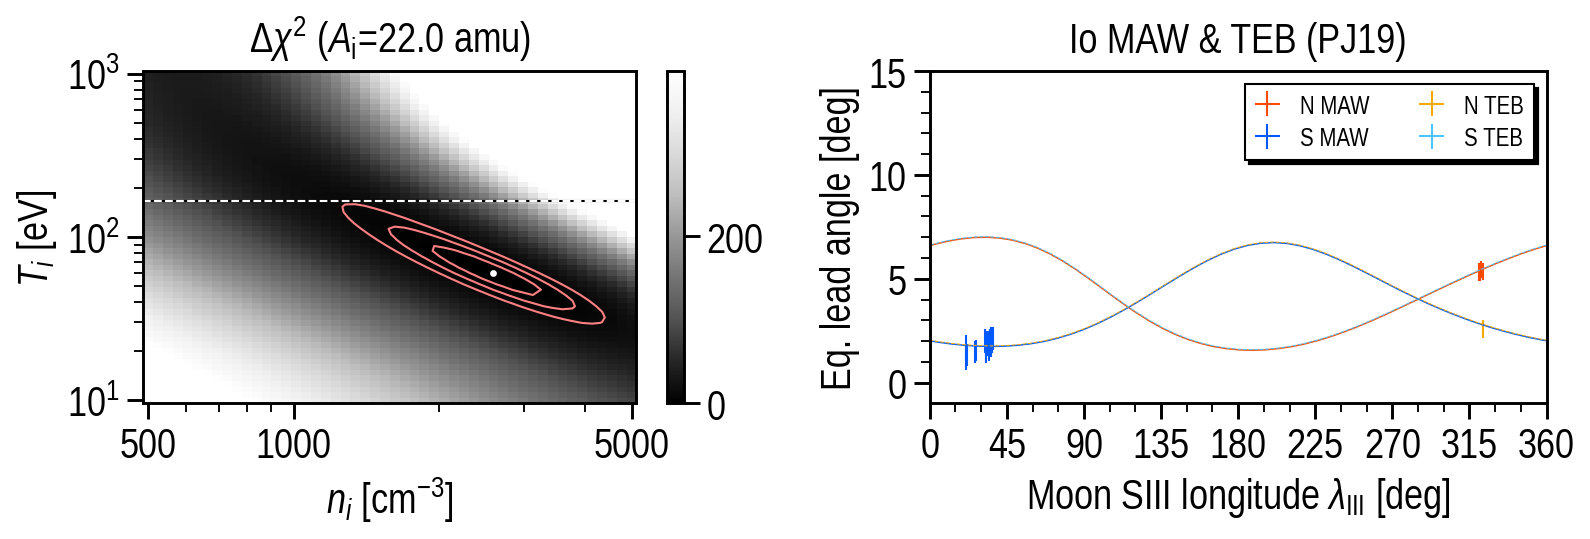

In [18]:
F = ShareXaxis()
F.fontsize = 20
F.fontname = 'Liberation Sans Narrow'
F.set_default()

fig, ax = plt.subplots(1, 2, figsize=(11, 4), dpi=150)

#
#
# FIRST AXIS
z_value = chi2_3d[:, 1, :].T-np.min(chi2_3d[:, 1, :])
x_value = ni_3d[:, 1, :].T
y_value = Ti_3d[:, 1, :].T

# Scale height (2.0 RJ) -> Ti
Ti_thres = ((2.0*RJ)**2)*Ai_3d[0, i, 0]/((0.64*RJ)**2) - Zi*Te

ax[0].set_title(
    r'$\Delta \chi^2$ ($A_{\rm i}$='+str(Ai_3d[0, 1, 0])+' amu)')
ax[0].set_xlabel(r'$n_i$ [cm$^{-3}$]')
ax[0].set_ylabel(r'$T_i$ [eV]')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks)
cn = ax[0].contour(x_value, y_value, z_value,
                   levels=[2.30, 6.17, 11.8],
                   # levels=[21.36, 30.48, 40.29],
                   colors=UC.pink,
                   linewidths=1.0,
                   zorder=2)
p = ax[0].pcolormesh(x_value,
                     y_value,
                     z_value,
                     cmap='Greys_r',
                     vmin=0, vmax=np.std(z_value), zorder=0.5)

# Location of the chi2 minimum
x_best = x_value[np.where(z_value == np.min(z_value))]
y_best = y_value[np.where(z_value == np.min(z_value))]
ax[0].scatter(x_best, y_best,
              s=5, color='w', zorder=2.5)

# Threshold temperature
ax[0].axhline(y=Ti_thres, linewidth=1.0, color='k')
ax[0].axhline(y=Ti_thres, linewidth=1.0, linestyle='--', color='w')

if TARGET_MOON == 'Europa':
    ax[0].scatter(1207/18, 87,
                  s=7, color=UC.lightblue,
                  marker='*', zorder=2.5)
    ax[0].scatter(1708/18, 195,
                  s=7, color=UC.lightblue,
                  marker='+', zorder=2.5)

fig.colorbar(p)

#
#
# SECOND AXIS
ax[1].set_title(fig_title, fontsize=F.fontsize)
ax[1].set_xlabel(
    r"Moon SIII longitude $\lambda_{\rm III}$ [deg]", fontsize=F.fontsize)
ax[1].set_ylabel('Eq. lead angle [deg]', fontsize=F.fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_ylim(-1, ymax)
ax[1].set_xticks(np.arange(0, 360+1, 45))
ax[1].set_xticklabels(np.arange(0, 360+1, 45))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_yticks(np.arange(0, ymax+1, 5))
ax[1].set_yticklabels(np.arange(0, ymax+1, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
north = np.where((hem_obs == -1))
ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
               xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
               yerr=np.array([np.abs(sigma_obs[north]),
                             np.abs(sigma_obs[north])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.red,
               label='N MAW',
               zorder=0.7)

south = np.where((hem_obs == 1))
ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
               xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
               yerr=np.array([np.abs(sigma_obs[south]),
                             np.abs(sigma_obs[south])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.blue,
               label='S MAW',
               zorder=0.7)

if len(target_fp) == 2:
    north = np.where((hem_obs == -101))
    ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
                   xerr=np.array([np.abs(sigma_x[north]),
                                 np.abs(sigma_x[north])]),
                   yerr=np.array([np.abs(sigma_obs[north]),
                                 np.abs(sigma_obs[north])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.orange,
                   label='N TEB',
                   zorder=0.7)
    south = np.where((hem_obs == 101))
    ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
                   xerr=np.array([np.abs(sigma_x[south]),
                                 np.abs(sigma_x[south])]),
                   yerr=np.array([np.abs(sigma_obs[south]),
                                 np.abs(sigma_obs[south])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.lightblue,
                   label='S TEB',
                   zorder=0.7)

ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_N,
           eqlead_best_MAW_N, color=UC.red, linewidth=0.7)
ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_S,
           eqlead_best_MAW_S, color=UC.blue, linewidth=0.7)

if len(target_fp) == 2:
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_N,
               eqlead_best_TEB_N, color=UC.orange,
               linestyle='--', linewidth=0.5)
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_S,
               eqlead_best_TEB_S, color=UC.lightblue,
               linestyle='--', linewidth=0.5)

fig.tight_layout()


legend1 = ax[1].legend(loc='upper right',
                       ncol=2,
                       fancybox=False,
                       facecolor='white',
                       framealpha=1,
                       edgecolor='k',
                       fontsize=F.fontsize*0.60,
                       labelspacing=0.34,
                       handlelength=1,)
legend1.set_zorder(102)
legend_shadow(fig=fig, ax=ax[1], legend=legend1)

plt.show()

## For paper publication

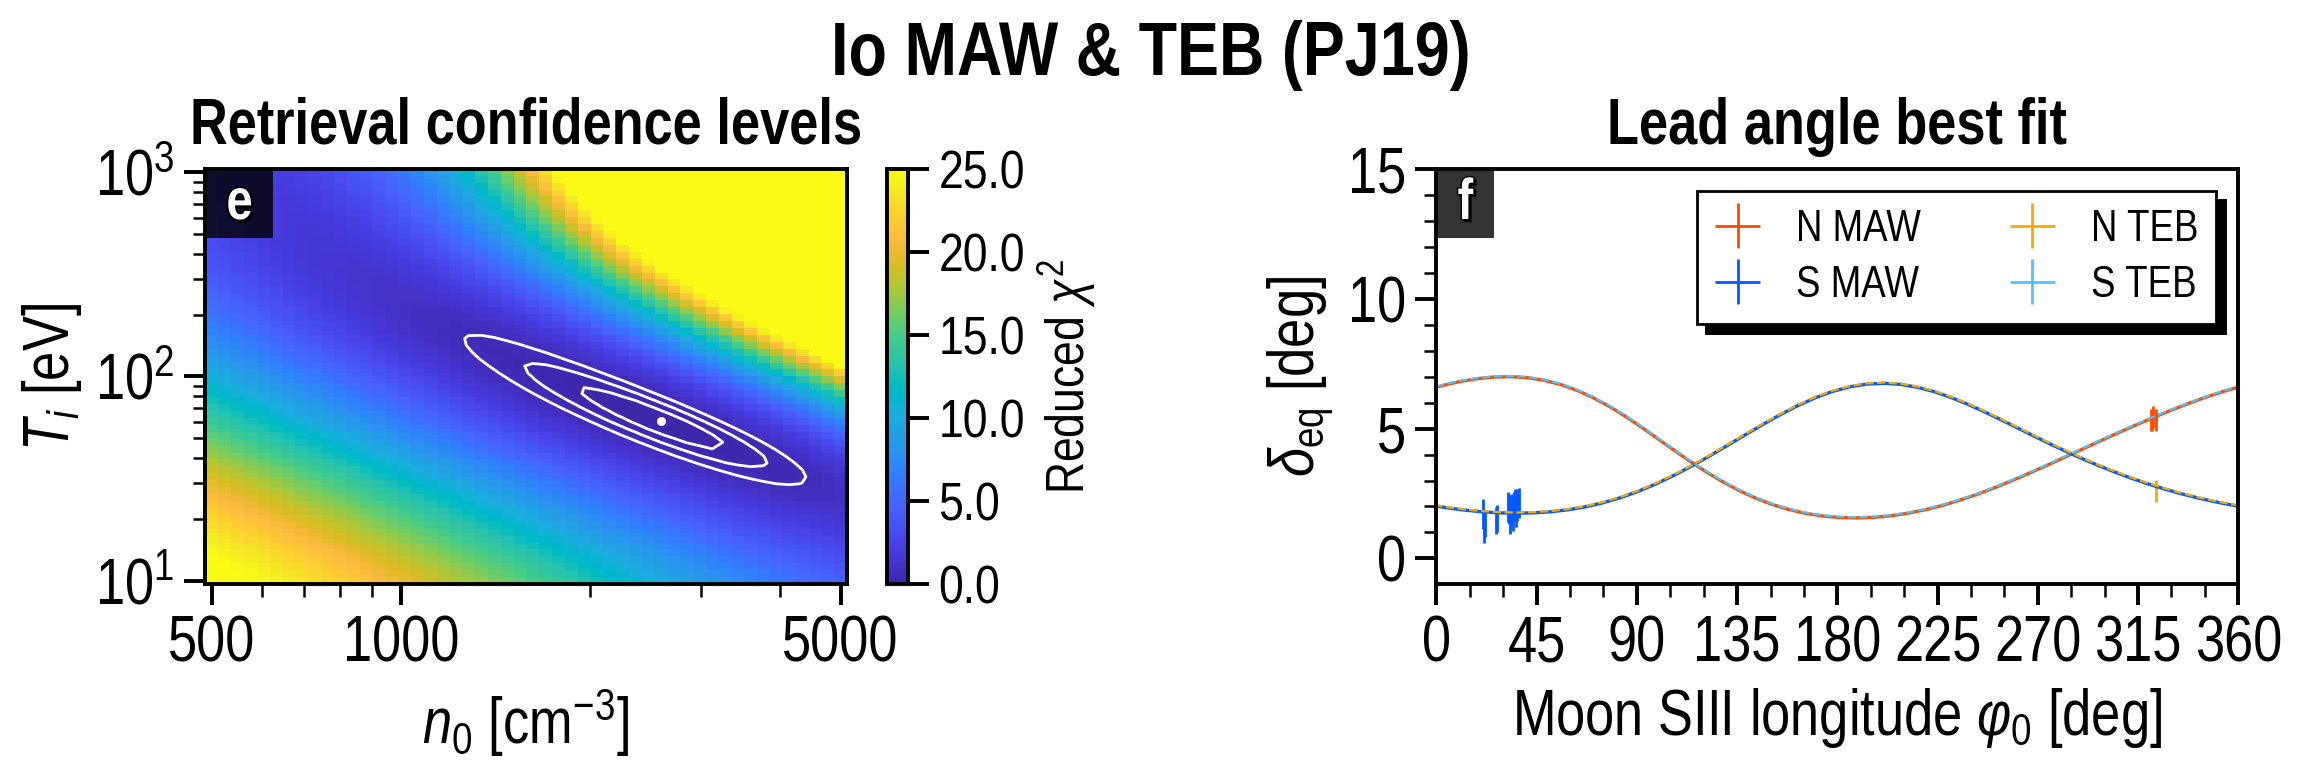

In [19]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'
F.set_default()

fig, ax = plt.subplots(1, 2, figsize=(12.0, 4.0), dpi=200)
fig.subplots_adjust(wspace=9)

F.fig, F.ax = fig, ax

#
#
# FIRST AXIS
z_value = chi2_3d[:, 1, :].T-np.min(chi2_3d[:, 1, :])
x_value = ni_3d[:, 1, :].T
y_value = Ti_3d[:, 1, :].T

# Scale height (2.0 RJ) -> Ti
Ti_thres = ((2.0*RJ)**2)*Ai_3d[0, i, 0]/((0.64*RJ)**2) - Zi*Te

parula = F._generate_cmap(F._parula_colors())

ax[0].set_title('Retrieval confidence levels', weight='bold')
ax[0].set_xlabel(r'$n_0$ [cm$^{-3}$]')
ax[0].set_ylabel(r'$T_i$ [eV]')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks)
cn = ax[0].contour(x_value, y_value, z_value,
                   levels=[2.30, 6.17, 11.8],
                   # levels=[21.36, 30.48, 40.29],
                   colors='w',
                   linewidths=1.0,
                   zorder=2)
p = ax[0].pcolormesh(x_value,
                     y_value,
                     z_value/(eqlead_est.shape[0]-3),
                     cmap=parula,
                     vmin=0, vmax=25, zorder=0.5)

# Location of the chi2 minimum
x_best = x_value[np.where(z_value == np.min(z_value))]
y_best = y_value[np.where(z_value == np.min(z_value))]
ax[0].scatter(x_best, y_best,
              s=5, color='w', zorder=2.5)

if TARGET_MOON == 'Europa':
    ax[0].scatter(1207/18, 87,
                  s=7, color=UC.lightblue,
                  marker='*', zorder=2.5)
    ax[0].scatter(1708/18, 195,
                  s=7, color=UC.lightblue,
                  marker='+', zorder=2.5)

cax = fig.colorbar(p)
cax.ax.set_yticks(np.linspace(0, 25, 6))
cax.ax.set_yticklabels(np.linspace(0, 25, 6), fontsize=F.fontsize*0.85)
cax.ax.set_ylabel(r'Reduced $\chi^2$', fontsize=F.fontsize*0.85)

#
#
# SECOND AXIS
ax[1].set_title('Lead angle best fit', weight='bold')
ax[1].set_xlabel(
    r"Moon SIII longitude $\varphi_0$ [deg]", fontsize=F.fontsize)
ax[1].set_ylabel(r'$\delta_{\rm eq}$ [deg]', fontsize=F.fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_ylim(-1, ymax)
ax[1].set_xticks(np.arange(0, 360+1, 45))
ax[1].set_xticklabels(np.arange(0, 360+1, 45))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_yticks(np.arange(0, ymax+1, 5))
ax[1].set_yticklabels(np.arange(0, ymax+1, 5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
north = np.where((hem_obs == -1))
ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
               xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
               yerr=np.array([np.abs(sigma_obs[north]),
                             np.abs(sigma_obs[north])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.red,
               label='N MAW',
               zorder=0.7)

south = np.where((hem_obs == 1))
ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
               xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
               yerr=np.array([np.abs(sigma_obs[south]),
                             np.abs(sigma_obs[south])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.blue,
               label='S MAW',
               zorder=0.7)

if len(target_fp) == 2:
    north = np.where((hem_obs == -101))
    ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
                   xerr=np.array([np.abs(sigma_x[north]),
                                 np.abs(sigma_x[north])]),
                   yerr=np.array([np.abs(sigma_obs[north]),
                                 np.abs(sigma_obs[north])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.orange,
                   label='N TEB',
                   zorder=0.7)
    south = np.where((hem_obs == 101))
    ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
                   xerr=np.array([np.abs(sigma_x[south]),
                                 np.abs(sigma_x[south])]),
                   yerr=np.array([np.abs(sigma_obs[south]),
                                 np.abs(sigma_obs[south])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.lightblue,
                   label='S TEB',
                   zorder=0.7)

ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_N,
           eqlead_best_MAW_N, color=UC.red, linewidth=1.2)
ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_S,
           eqlead_best_MAW_S, color=UC.blue, linewidth=1.2)

if len(target_fp) == 2:
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_N,
               eqlead_best_TEB_N, color=UC.orange,
               linestyle='--', linewidth=0.8)
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_S,
               eqlead_best_TEB_S, color=UC.lightblue,
               linestyle='--', linewidth=0.8)

#
#
# Panel names
panel_labels = [' e ', ' f ']
path_effects = [pe.PathPatchEffect(offset=(0.75, -0.75), linewidth=0.75, facecolor='k'),
                pe.withStroke(linewidth=1., foreground='k')]
for i in range(2):
    label_box = ax[i].annotate(
        panel_labels[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(0.16*20/F.fontsize, -0.16*20/F.fontsize), textcoords='offset fontsize',
        fontweight='bold',
        color='w',
        fontsize=F.fontsize*0.9,
        verticalalignment='top',
        horizontalalignment='left',
        path_effects=path_effects,
        bbox=dict(fc='k', ec='k', alpha=0.8, pad=2.6, lw=0.), zorder=99)

fig.tight_layout()

legend1 = ax[1].legend(loc='upper right',
                       ncol=2,
                       fancybox=False,
                       facecolor='white',
                       framealpha=1,
                       edgecolor='k',
                       fontsize=F.fontsize*0.7,
                       labelspacing=0.34,
                       handlelength=1,)
legend1.set_zorder(102)
legend_shadow(fig=fig, ax=ax[1], legend=legend1, d=1.1)

fig.suptitle(fig_title, y=1.01, weight='bold')
fig.savefig('figure_name2.pdf', bbox_inches='tight')
plt.show()

In [20]:
col_massdens_1d = np.loadtxt(
    'results/column_mass/003/20250516_'+TARGET_MOON+'/col_massdens_1d.txt')
col_massdens_3d = col_massdens_1d.reshape(ni_num, Ai_num, Ti_num)

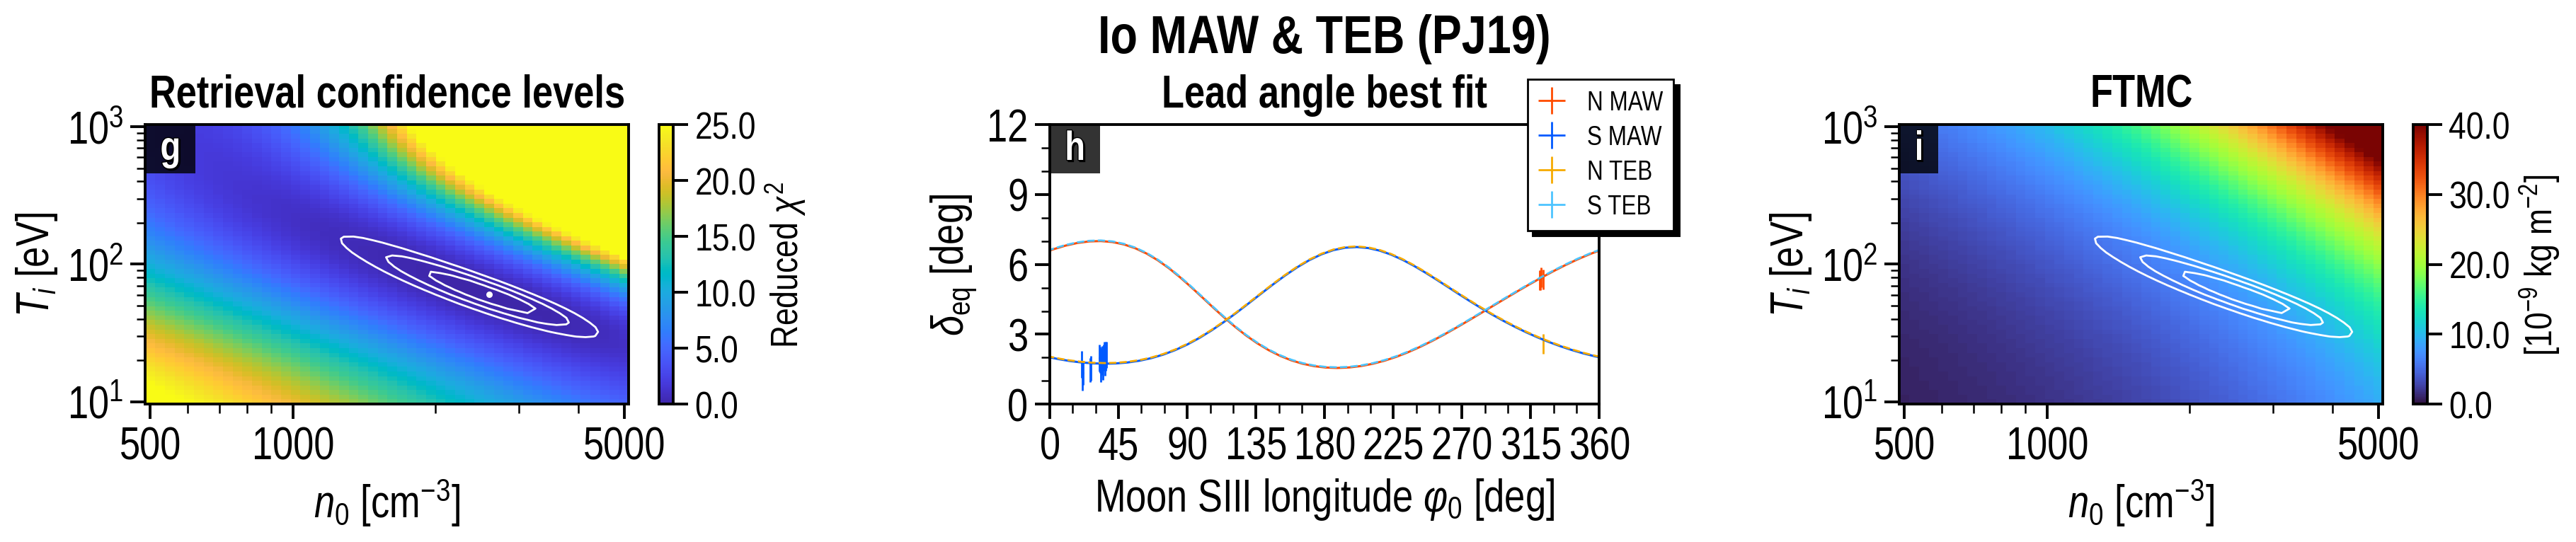

In [21]:
F = ShareXaxis()
F.fontsize = 23
F.fontname = 'Liberation Sans Narrow'
F.set_default()

fig, ax = plt.subplots(1, 3, figsize=(19.2, 3.9),
                       width_ratios=[1.1, 1, 1.1], dpi=200)
fig.subplots_adjust(wspace=5)

F.fig, F.ax = fig, ax

#
#
# FIRST AXIS
z_value = chi2_3d[:, 1, :].T-np.min(chi2_3d[:, 1, :])
x_value = ni_3d[:, 1, :].T
y_value = Ti_3d[:, 1, :].T
parula = F._generate_cmap(F._parula_colors())

ax[0].set_title('Retrieval confidence levels', weight='bold')
ax[0].set_xlabel(r'$n_0$ [cm$^{-3}$]')
ax[0].set_ylabel(r'$T_i$ [eV]')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks)
cn = ax[0].contour(x_value, y_value, z_value,
                   levels=[2.30, 6.17, 11.8],
                   # levels=[21.36, 30.48, 40.29],
                   colors='w',
                   linewidths=1.0,
                   zorder=2)
p = ax[0].pcolormesh(x_value,
                     y_value,
                     z_value/(eqlead_est.shape[0]-3),
                     cmap=parula,
                     vmin=0, vmax=25, zorder=0.5)

# Location of the chi2 minimum
x_best = x_value[np.where(z_value == np.min(z_value))]
y_best = y_value[np.where(z_value == np.min(z_value))]
ax[0].scatter(x_best, y_best,
              s=5, color='w', zorder=2.5)

if TARGET_MOON == 'Europa':
    ax[0].scatter(1207/18, 87,
                  s=7, color=UC.lightblue,
                  marker='*', zorder=2.5)
    ax[0].scatter(1708/18, 195,
                  s=7, color=UC.lightblue,
                  marker='+', zorder=2.5)

cax = fig.colorbar(p, ax=ax[0])
cax.ax.set_yticks(np.linspace(0, 25, 6))
cax.ax.set_yticklabels(np.linspace(0, 25, 6), fontsize=F.fontsize*0.85)
cax.ax.set_ylabel(r'Reduced $\chi^2$', fontsize=F.fontsize*0.85)


#
#
# SECOND AXIS
ax[1].set_title('Lead angle best fit', weight='bold')
ax[1].set_xlabel(
    r"Moon SIII longitude $\varphi_0$ [deg]", fontsize=F.fontsize)
ax[1].set_ylabel(r'$\delta_{\rm eq}$ [deg]', fontsize=F.fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_ylim(0, 12)
ax[1].set_xticks(np.arange(0, 360+1, 45))
ax[1].set_xticklabels(np.arange(0, 360+1, 45))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_yticks(np.arange(0, 12+1, 3))
ax[1].set_yticklabels(np.arange(0, 12+1, 3))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
north = np.where((hem_obs == -1))
ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
               xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
               yerr=np.array([np.abs(sigma_obs[north]),
                             np.abs(sigma_obs[north])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.red,
               label='N MAW',
               zorder=0.7)

south = np.where((hem_obs == 1))
ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
               xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
               yerr=np.array([np.abs(sigma_obs[south]),
                             np.abs(sigma_obs[south])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.blue,
               label='S MAW',
               zorder=0.7)

if len(target_fp) == 2:
    north = np.where((hem_obs == -101))
    ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
                   xerr=np.array([np.abs(sigma_x[north]),
                                 np.abs(sigma_x[north])]),
                   yerr=np.array([np.abs(sigma_obs[north]),
                                 np.abs(sigma_obs[north])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.orange,
                   label='N TEB',
                   zorder=0.7)
    south = np.where((hem_obs == 101))
    ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
                   xerr=np.array([np.abs(sigma_x[south]),
                                 np.abs(sigma_x[south])]),
                   yerr=np.array([np.abs(sigma_obs[south]),
                                 np.abs(sigma_obs[south])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.lightblue,
                   label='S TEB',
                   zorder=0.7)

ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_N,
           eqlead_best_MAW_N, color=UC.red, linewidth=1.1)
ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_S,
           eqlead_best_MAW_S, color=UC.blue, linewidth=1.1)

if len(target_fp) == 2:
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_N,
               eqlead_best_TEB_N, color=UC.orange,
               linestyle='--', linewidth=1.0)
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_S,
               eqlead_best_TEB_S, color=UC.lightblue,
               linestyle='--', linewidth=1.0)


#
#
# THIRD AXIS
z_value_2 = col_massdens_3d[:, 1, :].T
z_value_2 = z_value_2*1E+9
x_value_2 = ni_3d[:, 1, :].T
y_value_2 = Ti_3d[:, 1, :].T

ax[2].set_title('FTMC', weight='bold')
ax[2].set_xlabel(r'$n_0$ [cm$^{-3}$]')
ax[2].set_ylabel(r'$T_i$ [eV]')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xticks(xticks)
ax[2].set_xticklabels(xticks)
cn = ax[2].contour(x_value, y_value, z_value,
                   levels=[2.30, 6.17, 11.8],
                   # levels=[21.36, 30.48, 40.29],
                   colors='w',
                   linewidths=1.0,
                   zorder=2)
p = ax[2].pcolormesh(x_value_2,
                     y_value_2,
                     z_value_2,
                     cmap='turbo',
                     vmin=0, vmax=40,
                     zorder=0.5)

cax = fig.colorbar(p, ax=ax[2])
cax.ax.set_yticks(np.linspace(0, 40, 5))
cax.ax.set_yticklabels(np.linspace(0, 40, 5), fontsize=F.fontsize*0.85)
cax.ax.set_ylabel(r'[$10^{-9}$ kg m$^{-2}$]', fontsize=F.fontsize*0.85)


#
#
# Panel names
panel_labels = [' g ', ' h ', ' i ']
path_effects = [pe.PathPatchEffect(offset=(0.75, -0.75), linewidth=0.75, facecolor='k'),
                pe.withStroke(linewidth=1., foreground='k')]
for i in range(3):
    label_box = ax[i].annotate(
        panel_labels[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(0.16*20/F.fontsize, -0.16*20/F.fontsize), textcoords='offset fontsize',
        fontweight='bold',
        color='w',
        fontsize=F.fontsize*0.9,
        verticalalignment='top',
        horizontalalignment='left',
        path_effects=path_effects,
        bbox=dict(fc='k', ec='k', alpha=0.8, pad=2.6, lw=0.), zorder=99)

fig.tight_layout()

legend1 = ax[1].legend(loc='upper right',
                       bbox_to_anchor=[1.16, 1.21],
                       ncol=1,
                       fancybox=False,
                       facecolor='white',
                       framealpha=1,
                       edgecolor='k',
                       fontsize=F.fontsize*0.6,
                       labelspacing=0.34,
                       handlelength=1,)
legend1.set_zorder(102)
legend_shadow(fig=fig, ax=ax[1], legend=legend1, d=2.4)

fig.suptitle(fig_title, y=1.02, weight='bold')
fig.savefig('figure_name2.pdf', bbox_inches='tight')
fig.savefig('figure_name2.png', bbox_inches='tight')
plt.show()

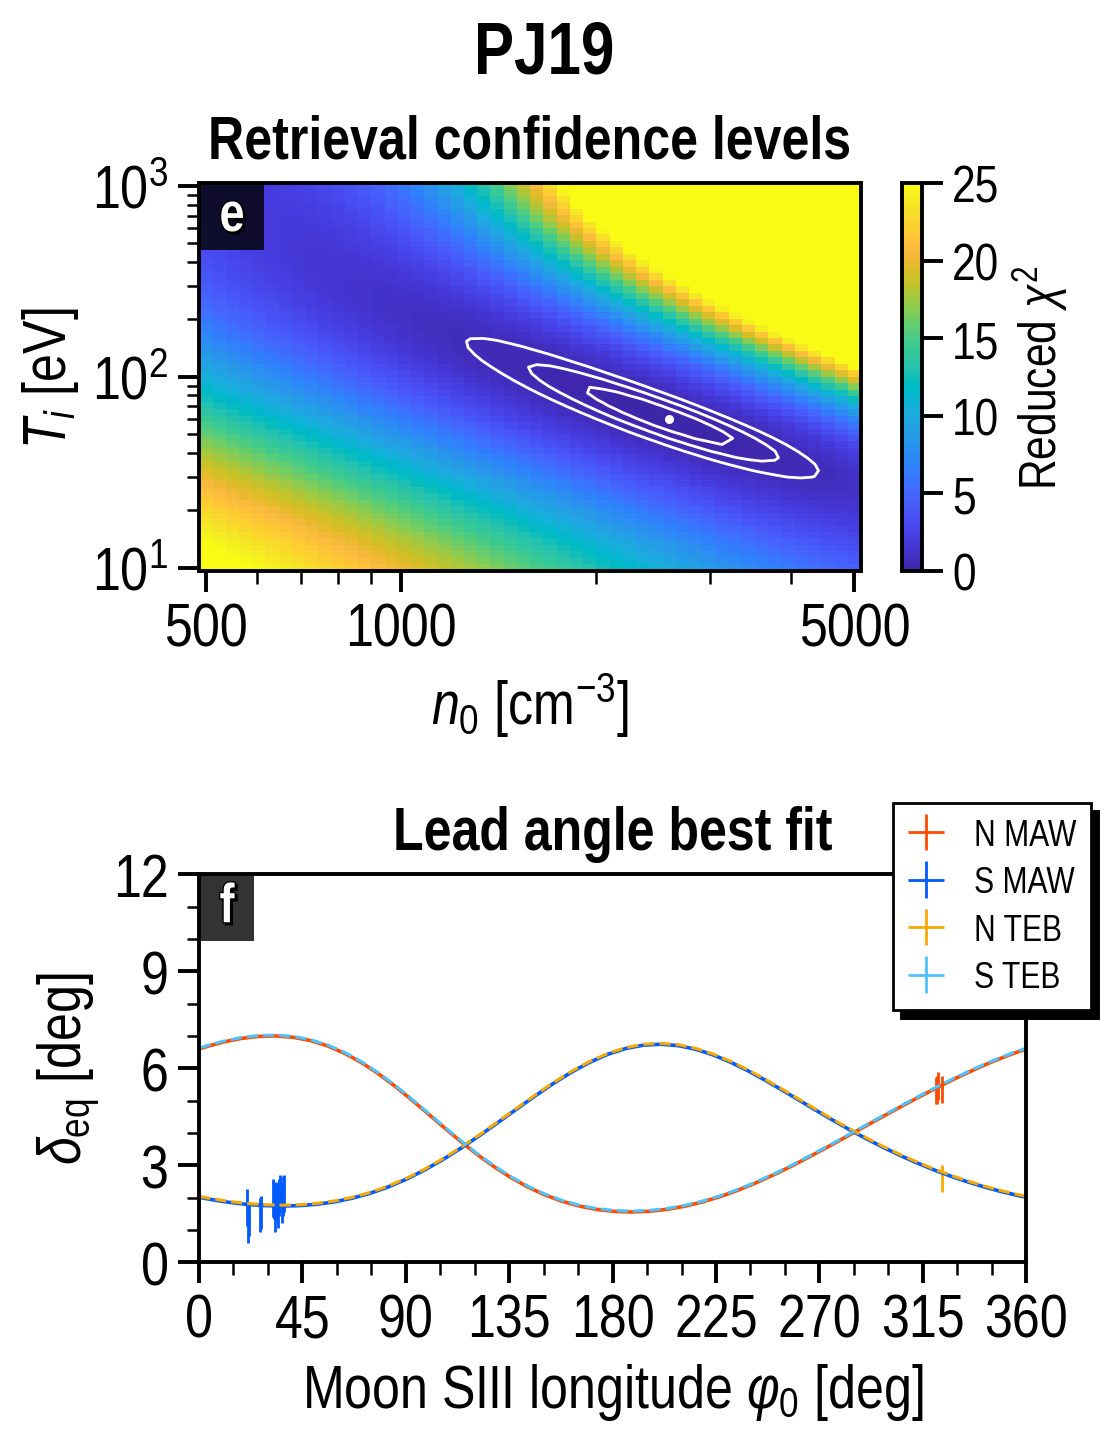

In [22]:
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'
F.set_default()

fig, ax = plt.subplots(2, 1, figsize=(5.9, 7.2),
                       dpi=200)
fig.subplots_adjust(hspace=0.8)

F.fig, F.ax = fig, ax

# First axis
z_value = chi2_3d[:, 1, :].T-np.min(chi2_3d[:, 1, :])
x_value = ni_3d[:, 1, :].T
y_value = Ti_3d[:, 1, :].T
parula = F._generate_cmap(F._parula_colors())

ax[0].set_title('Retrieval confidence levels', weight='bold')
ax[0].set_xlabel(r'$n_0$ [cm$^{-3}$]')
ax[0].set_ylabel(r'$T_i$ [eV]')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks)
cn = ax[0].contour(x_value, y_value, z_value,
                   levels=[2.30, 6.17, 11.8],
                   # levels=[21.36, 30.48, 40.29],
                   colors='w',
                   linewidths=1.0,
                   zorder=2)
p = ax[0].pcolormesh(x_value,
                     y_value,
                     z_value/(eqlead_est.shape[0]-3),
                     cmap=parula,
                     vmin=0, vmax=25, zorder=0.5)

# Location of the chi2 minimum
x_best = x_value[np.where(z_value == np.min(z_value))]
y_best = y_value[np.where(z_value == np.min(z_value))]
ax[0].scatter(x_best, y_best,
              s=5, color='w', zorder=2.5)

# Colorbar
cax = fig.colorbar(p, ax=ax[0])
cax.ax.set_yticks(np.linspace(0, 25, 6))
cax.ax.set_yticklabels(np.linspace(0, 25, 6, dtype=int),
                       fontsize=F.fontsize*0.85)
cax.ax.set_ylabel(r'Reduced $\chi^2$', fontsize=F.fontsize*0.85)

# Second axis
# SECOND AXIS
ax[1].set_title('Lead angle best fit', weight='bold')
ax[1].set_xlabel(
    r"Moon SIII longitude $\varphi_0$ [deg]", fontsize=F.fontsize)
ax[1].set_ylabel(r'$\delta_{\rm eq}$ [deg]', fontsize=F.fontsize)
ax[1].set_xlim(0, 360)
ax[1].set_ylim(0, 12)
ax[1].set_xticks(np.arange(0, 360+1, 45))
ax[1].set_xticklabels(np.arange(0, 360+1, 45))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax[1].set_yticks(np.arange(0, 12+1, 3))
ax[1].set_yticklabels(np.arange(0, 12+1, 3))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
north = np.where((hem_obs == -1))
ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
               xerr=np.array([np.abs(sigma_x[north]),
                             np.abs(sigma_x[north])]),
               yerr=np.array([np.abs(sigma_obs[north]),
                             np.abs(sigma_obs[north])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.red,
               label='N MAW',
               zorder=0.7)

south = np.where((hem_obs == 1))
ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
               xerr=np.array([np.abs(sigma_x[south]),
                             np.abs(sigma_x[south])]),
               yerr=np.array([np.abs(sigma_obs[south]),
                             np.abs(sigma_obs[south])]),
               linewidth=0., markersize=2,
               elinewidth=1.0, color=UC.blue,
               label='S MAW',
               zorder=0.7)

if len(target_fp) == 2:
    north = np.where((hem_obs == -101))
    ax[1].errorbar(moon_S3wlon_obs[north], eqlead_obs[north],
                   xerr=np.array([np.abs(sigma_x[north]),
                                 np.abs(sigma_x[north])]),
                   yerr=np.array([np.abs(sigma_obs[north]),
                                 np.abs(sigma_obs[north])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.orange,
                   label='N TEB',
                   zorder=0.7)
    south = np.where((hem_obs == 101))
    ax[1].errorbar(moon_S3wlon_obs[south], eqlead_obs[south],
                   xerr=np.array([np.abs(sigma_x[south]),
                                 np.abs(sigma_x[south])]),
                   yerr=np.array([np.abs(sigma_obs[south]),
                                 np.abs(sigma_obs[south])]),
                   linewidth=0., markersize=2,
                   elinewidth=1.0, color=UC.lightblue,
                   label='S TEB',
                   zorder=0.7)

ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_N,
           eqlead_best_MAW_N, color=UC.red, linewidth=1.3)
ax[1].plot(S3wlon_A0_arr+eqlead_best_MAW_S,
           eqlead_best_MAW_S, color=UC.blue, linewidth=1.3)

if len(target_fp) == 2:
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_N,
               eqlead_best_TEB_N, color=UC.orange,
               linestyle='--', linewidth=1.1)
    ax[1].plot(S3wlon_A0_arr+eqlead_best_TEB_S,
               eqlead_best_TEB_S, color=UC.lightblue,
               linestyle='--', linewidth=1.1)

# Panel names
panel_labels = [' e ', ' f ']
path_effects = [pe.PathPatchEffect(offset=(0.75, -0.75), linewidth=0.75, facecolor='k'),
                pe.withStroke(linewidth=1., foreground='k')]
for i in range(2):
    label_box = ax[i].annotate(
        panel_labels[i],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(0.16*20/F.fontsize, -0.16*20/F.fontsize), textcoords='offset fontsize',
        fontweight='bold',
        color='w',
        fontsize=F.fontsize*0.9,
        verticalalignment='top',
        horizontalalignment='left',
        path_effects=path_effects,
        bbox=dict(fc='k', ec='k', alpha=0.8, pad=2.6, lw=0.), zorder=99)
fig.tight_layout()

legend1 = ax[1].legend(loc='upper right',
                       bbox_to_anchor=[1.10, 1.23],
                       ncol=1,
                       fancybox=False,
                       facecolor='white',
                       framealpha=1,
                       edgecolor='k',
                       fontsize=F.fontsize*0.6,
                       labelspacing=0.34,
                       handlelength=1,)
legend1.set_zorder(102)
legend_shadow(fig=fig, ax=ax[1], legend=legend1, d=2.6)

fig.suptitle('PJ'+PJ_num[0], y=1.02, weight='bold')
fig.savefig('figure_PJ'+PJ_num[0]+'.pdf', bbox_inches='tight')
plt.show()

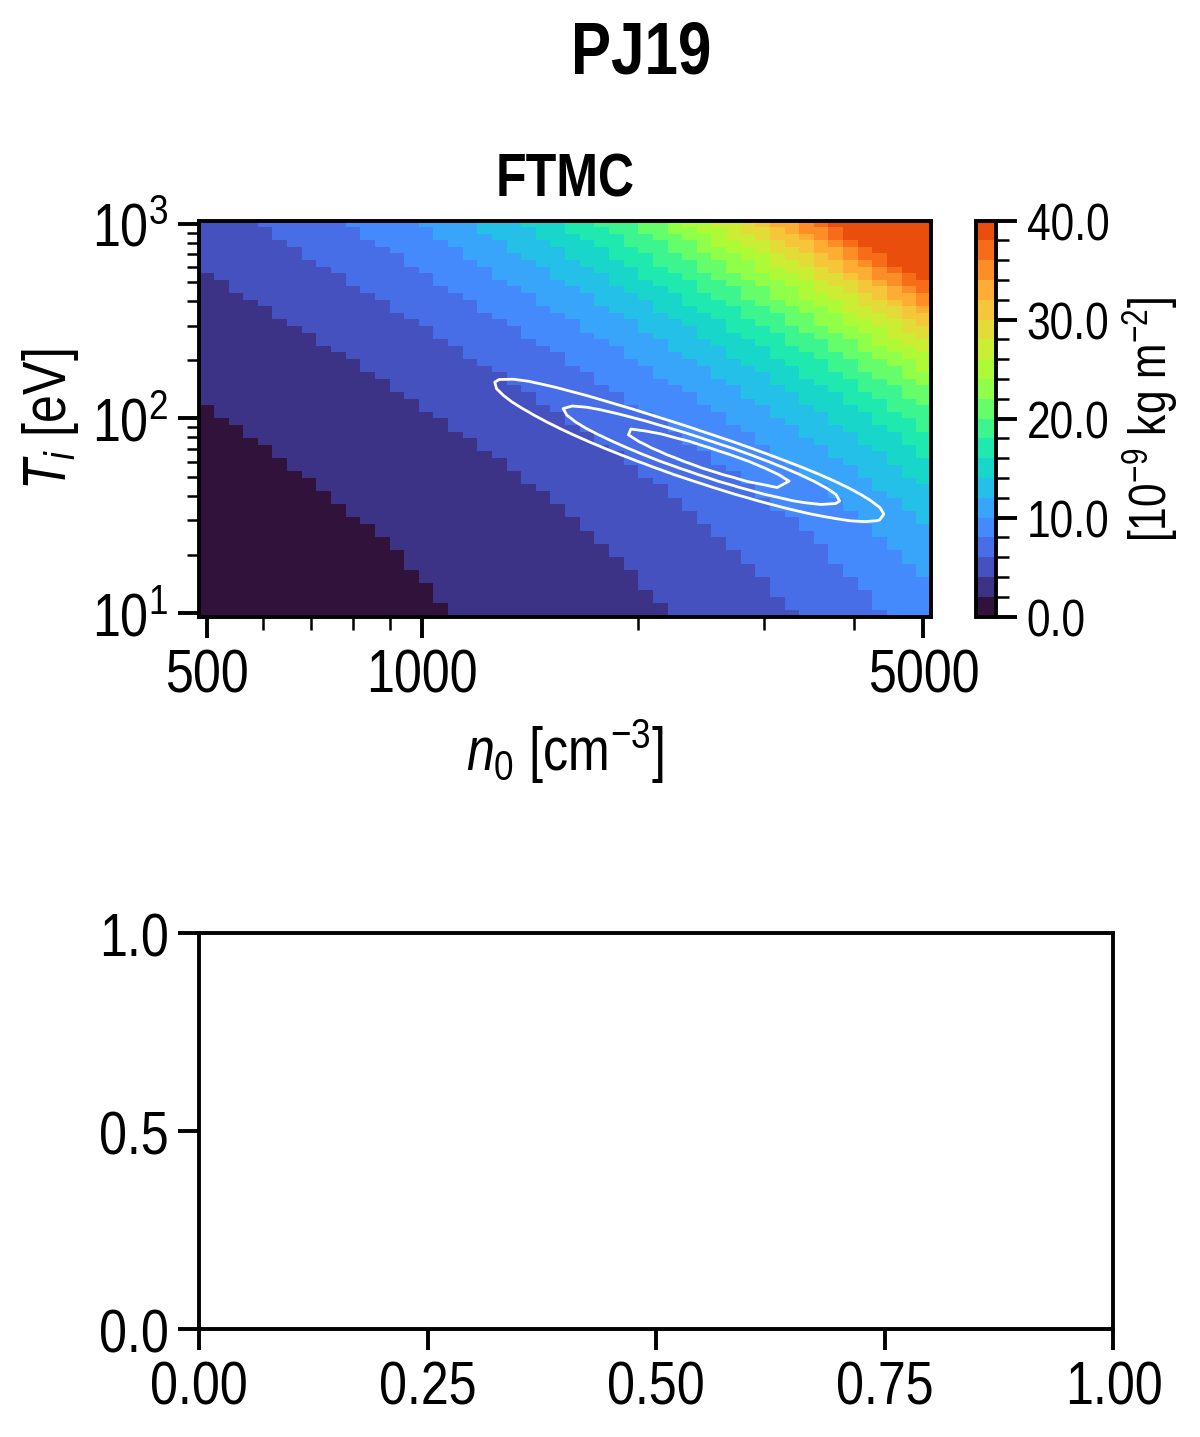

In [23]:
F = ShareXaxis()
F.fontsize = 22
F.fontname = 'Liberation Sans Narrow'
F.set_default()

fig, ax = plt.subplots(2, 1, figsize=(5.9, 7.2),
                       dpi=200)
fig.subplots_adjust(hspace=0.8)

F.fig, F.ax = fig, ax

#
#
# THIRD AXIS
z_value_2 = col_massdens_3d[:, 1, :].T
z_value_2 = z_value_2*1E+9
x_value_2 = ni_3d[:, 1, :].T
y_value_2 = Ti_3d[:, 1, :].T

ax[0].set_title('FTMC', weight='bold')
ax[0].set_xlabel(r'$n_0$ [cm$^{-3}$]')
ax[0].set_ylabel(r'$T_i$ [eV]')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks)
cn = ax[0].contour(x_value, y_value, z_value,
                   levels=[2.30, 6.17, 11.8],
                   # levels=[21.36, 30.48, 40.29],
                   colors='w',
                   linewidths=1.0,
                   zorder=2)

cmap_turbo = plt.get_cmap('turbo')
N_color = 20
dN = int(256/N_color-1)
color_list = []
for i in range(N_color):
    color_list += [cmap_turbo(i*dN)]
cmap = mplcolors.ListedColormap(color_list)
norm = mplcolors.Normalize(vmin=0, vmax=40)

p = ax[0].pcolormesh(x_value_2,
                     y_value_2,
                     z_value_2,
                     cmap=cmap,
                     norm=norm,
                     zorder=0.5)

# Setting for color bar
cmap_turbo = plt.get_cmap('turbo')
cmap_turbo(0)
color_list = [cmap_turbo(0), cmap_turbo(63), cmap_turbo(127), cmap_turbo(195)]
cmap = mplcolors.ListedColormap(color_list)
norm = mplcolors.Normalize(vmin=0, vmax=1)

cax = fig.colorbar(p, ax=ax[0])
cax.ax.set_yticks(np.linspace(0, 40, 5))
cax.ax.set_yticklabels(np.linspace(0, 40, 5), fontsize=F.fontsize*0.85)
cax.ax.yaxis.set_minor_locator(ptick.AutoMinorLocator(5))
cax.ax.set_ylabel(r'[$10^{-9}$ kg m$^{-2}$]', fontsize=F.fontsize*0.85)

fig.suptitle('PJ'+PJ_num[0], y=1.02, weight='bold')
plt.show()